In [1]:
from PIL import Image
import numpy as np
import pandas as pd

# Import images 
full_img = Image.open('../../res/tp3/cow.jpg').convert('RGB')

sky_img = Image.open('../../res/tp3/cielo.jpg')
grass_img = Image.open('../../res/tp3/pasto.jpg')
cow_img = Image.open('../../res/tp3/vaca.jpg')


cow_pixels = list(map(lambda x: [x[0], x[1], x[2], 'cow'], cow_img.getdata()))
grass_pixels = list(map(lambda x: [x[0], x[1], x[2], 'grass'], grass_img.getdata()))
sky_pixels = list(map(lambda x: [x[0], x[1], x[2], 'sky'], sky_img.getdata()))

pixels = cow_pixels + grass_pixels + sky_pixels

df = pd.DataFrame(pixels, columns=['r', 'g', 'b', 'class'])
df.head()

,r,g,b,class
0,225,152,99,cow
1,237,164,113,cow
2,223,152,100,cow
3,206,134,84,cow
4,215,145,94,cow


In [2]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def get_svm(data, kernel='linear', C=1.0, verbose=False):
    X = np.array(list(map(lambda point: (point[0], point[1], point[2]), data)))
    y = list(map(lambda point: point[3], data))

    # Create a linear SVM classifier
    clf = SVC(kernel=kernel, C=C, verbose=verbose)

    # Train classifier
    clf.fit(X, y)
    
    return X, y, clf

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

train, test = train_test_split(pixels, test_size=0.2)

X, y, clf = get_svm(train, verbose=True)

[LibSVM]

In [5]:
import time

kernels = ['rbf', 'poly', 'linear', 'sigmoid']
c_values = [1.0, 10.0, 100.0, 1000.0]

img_dict = {'cow': 1, 'grass': 2, 'sky': 3}

kernel_results = {kernel: {} for kernel in kernels}

for c_value in c_values:
    for kernel in kernels:
        start = time.time()
        X, y, clf = get_svm(train, kernel=kernel, C=c_value)
        kernel_results[kernel][c_value] = (X, y, clf)
        end = time.time()
        print(f'Done with kernel {kernel} and C={int(c_value)} in {end - start} seconds')


Done with kernel poly and C=1 in 10.947931051254272 seconds
Done with kernel rbf and C=1 in 10.87401008605957 seconds
Done with kernel poly and C=10 in 14.201246738433838 seconds
Done with kernel rbf and C=10 in 10.665608882904053 seconds
Done with kernel poly and C=100 in 43.97744607925415 seconds
Done with kernel rbf and C=100 in 9.759527921676636 seconds
Done with kernel poly and C=1000 in 301.89313888549805 seconds
Done with kernel rbf and C=1000 in 14.183302879333496 seconds


In [25]:
# Get class value from test dataset
y_test = list(map(lambda y: y[3], test)) 


# Get predicted class value from test dataset
y_pred = list(map(lambda pixel: clf.predict([[pixel[0], pixel[1], pixel[2]]]), test))

[193, 208, 215, 'sky']


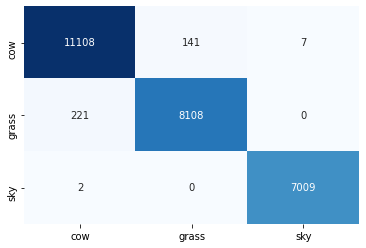

In [44]:
import seaborn as sns

# Plot confusion matrix for classifier 

conf_matrix = confusion_matrix(y_test, y_pred)
count_values = list(map(lambda x: sum(x), conf_matrix))

unique, counts = np.unique(np.array(y_test), return_counts=True)
count_labels = dict(zip(counts, unique))

labels = []
for value in count_values:
    labels.append(count_labels[value])

matrix = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False) 

In [42]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         cow       0.98      0.99      0.98     11256
       grass       0.98      0.97      0.98      8329
         sky       1.00      1.00      1.00      7011

    accuracy                           0.99     26596
   macro avg       0.99      0.99      0.99     26596
weighted avg       0.99      0.99      0.99     26596



In [49]:
def normalize_img(pixels):
    result = np.zeros(pixels.shape)
    for i in range(pixels.shape[2]):
        band = pixels[:,:,i]
        minimum = band.min()
        maximum = band.max()
        result[:,:,i] = 255 * (np.subtract(band, minimum)) / (maximum - minimum)
    
    return result


In [48]:
class_color_dict = {'sky': [0, 0, 255], 'grass': [0, 255, 0], 'cow': [255, 0, 0]}

full_img_pixels = np.asarray(full_img, dtype=np.uint8)
class_sections_pixels = np.zeros(full_img_pixels.shape)
for i in range(full_img_pixels.shape[0]):
    for j in range(full_img_pixels.shape[1]):
        predicted = clf.predict([full_img_pixels[i,j,:]])[0]
        class_sections_pixels[i,j,:] = class_color_dict[predicted]


In [50]:
result = normalize_img(full_img_pixels + class_sections_pixels)

img = Image.fromarray(result.astype(np.uint8), 'RGB')
img.save('result.png')
img.show()